## **Notebook for all the little code snippets for the code cleaning of stareg**

TODOs:
- [x] B-spline
- [x] TP-Bspline
- [x] Penalty and smoothness matrices
- [ ] check_constraint
- [ ] star_model

I'll try to use as little external libraries as possible.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.sparse import diags
from scipy.linalg import block_diag
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


In [2]:
class Bspline():
    
    def basisfunction(self, X, knots, j, l):
        """B-spline basis function definition according to Fahrmeir, Regression p.429

        Parameters:
        -----------
        X :      array   - Input data of shape (n_samples, ) to evaluate the B-spline basis function 
                           of order l on.
        knots :  array   - Knot sequence defining the B-spline basis function.
        j :      int     - Index of the B-spline basis function to evaluate.
        l :      int     - Order of the B-spline basis function, e.g. l=3 -> cubic.

        Returns:
        --------
        b : array     - B-spline basis function evaluated at X. 

        """
        if l == 0:
            b = ((knots[j] <= X) & (X < knots[j+1])).astype(int)
            return b
        else:
            b0 = (X - knots[j-l]) / (knots[j] - knots[j-l])
            b1 = (knots[j+1] - X) / (knots[j+1] - knots[j+1-l])
            b = b0*self.basisfunction(X, knots, j-1, l-1) + b1*self.basisfunction(X, knots, j, l-1)
            return b


    def basismatrix(self, X, nr_splines=10, l=3, knot_type="e"):
        """Generate the B-spline basis matrix for nr_splines given the data X.

         Note: (nr_splines + l + 1) knots are needed for a B-spline basis of 
               order l with nr_splines, e.g. for l=3, nr_splines=10 -> len(knots) = 14. 

         Parameters:
         ----------
         X :          array  -  Input data of shape (n_samples, ) to compute the B-spline basis matrix for.
         nr_splines : int    -  Number of parameters (== number of B-spline basis functions).
         l :          int    -  Specifies the order of the B-spline basis functions.
         knot_type :  str    -  Decide between equidistant "e" and quantile based "q"
                                knot placement.

         Returns:
         --------
         B : matrix  - B-spline basis matrix of shape: ( length(x) x nr_splines ).
         k : array   - Knot sequence.

        """
        assert (len(X.shape) == 1), "Argument X is of wrong shape."
        B = np.zeros((len(X), nr_splines))
        xmin, xmax = X.min(), X.max()

        if knot_type is "e":
            knots_inner = np.linspace(xmin, xmax, nr_splines-l+1)
        elif knot_type is "q":
            p = np.linspace(0, 1, nr_splines-l+1);
            xs = np.sort(X, kind="quicksort")
            quantile_idx = np.array((len(X)-1)*p, dtype=np.int16)
            knots_inner = xs[quantile_idx]
        else:
            print(f"Knot Type {knot_type} not implemented!")
        
        dknots = np.diff(knots_inner).mean()
        knots_left = np.linspace(xmin-l*dknots, xmin-dknots, l)
        knots_right = np.linspace(xmax+dknots, xmax+l*dknots, l)
        knots = np.concatenate((knots_left, knots_inner, knots_right))

        for j in range(l,len(knots)-1):
            B[:,j-l] = self.basisfunction(X, knots, j, l);

        self.knot_type = knot_type
        self.l = l
        self.basis = B
        self.knots = knots
        return dict(basis=B, knots=knots)

    def fit(self, X, y, nr_splines=10, l=3, knot_type="e"):
        """Calculate the least squares parameters of the B-spline given the data X.

        Parameters:
        -----------
        X : array        - Input data of shape (n_samples, ).
        y : array        - Output data of shape (n_samples, ).
        nr_splines : int - Nr. of B-spline basis functions to use.
        l : int          - Order of the B-spline basis functions.
        knot_type : str  - Specifies the type of the knot sequence, either "e" or "q".

        Returns:
        --------
        coef_ : array  - Estimated coefficients of shape (nr_splines, ).
        B : matrix     - B-spline basis matrix.
        k : array      - Knot sequence 
        """
        if len(X.shape) == 1:
            B, k = self.basismatrix(X=X, nr_splines=nr_splines, l=l, knot_type=knot_type).values()
        elif X.shape[1] == 2:
            B, k1, k2 = self.tensorproduct_basismatrix(X=X, nr_splines=nr_splines, l=l, knot_type=knot_type).values()
            k = (k1, k2)
        else:
            print("Maximal dimension == 2!")
            return 
        solution = np.linalg.lstsq(a=B, b=y, rcond=None)      
        self.coef_ = solution[0]
        return dict(coef_=solution[0], basis=B, knots=k) 

    def predict(self, Xpred, coef, knots, l=3):
        """Calculate the B-spline value for X given the parameters in coef.

        Paramters:
        ----------
        X : array      - Data of shape (n_samples, ) to evaluate the B-spline on.
        coef  : array  - Parameters of the B-spline.
        knots : array  - Knot sequence of the B-spline.
        l : int        - Order of the B-spline.

        Returns:
        --------
        s : array   - B-spline values on X for the given parameters.

        """
        if len(Xpred.shape) == 1:
            print("Prediction for 1-D Data".center(30, "-"))
            B = np.zeros((len(Xpred), len(coef)))
            for j in range(l, len(knots)-1):
                B[:,j-l] = self.basisfunction(Xpred, knots, j, l)
                
        elif Xpred.shape[1] == 2:
            print("Prediction for 2-D Data".center(30, "-"))
            n_samples = len(Xpred[:,0])
            B1pred, B2pred = np.zeros((n_samples, len(knots[0])-1-l[0])), np.zeros((n_samples, len(knots[1])-1-l[1]))
            B = np.zeros((n_samples, len(coef)))

            for j in range(l[0], len(knots[0])-1):
                B1pred[:,j-l[0]] = self.basisfunction(Xpred[:,0], knots[0], j, l[0]) 
            for j in range(l[1], len(knots[1])-1):
                B2pred[:,j-l[1]] = self.basisfunction(Xpred[:,1], knots[1], j, l[1]) 
            for i in range(n_samples):
                B[i,:] = np.kron(B2pred[i,:], B1pred[i,:])    
        else:
            print("Maximal dimension == 2!")
            return 
        s = B @ coef
        return s    

    def tensorproduct_basismatrix(self, X, nr_splines=(7,7), l=(3,3), knot_type=("e", "e")):
        """Generate the 2-d tensor-product B-spline basis matrix for nr_splines[0] and
        nr_splines[1] for dimension 1 and 2.

        Parameters
        ----------
        X : array          - Input data of shape (n_samples, 2)
        nr_splines : list  - Contains the number of B-spline basis functions for each dimension.
        l : list           - Spline order for each dimensions.
        knot_type : list   - Knot types for each dimension.

        Returns:
        --------
        T  : matrix   - Tensor-product B-spline basis.
        k1 : array    - Knot sequence of dimension 1.
        k2 : array    - Knot sequence of dimension 2.
        """
        BS = Bspline()
        B1, k1 = BS.basismatrix(X[:,0], nr_splines[0], l[0], knot_type[0]).values()
        B2, k2 = BS.basismatrix(X[:,1], nr_splines[1], l[1], knot_type[1]).values()

        n_samples, n_dim = X.shape
        T = np.zeros((n_samples, nr_splines[0]*nr_splines[1]))
        for i in range(n_samples):
            T[i,:] = np.kron(B2[i,:], B1[i,:])

        self.basis = T
        self.knots = (k1, k2)
        return dict(basis=T, knots1=k2, knots2=k2)

    
    def fit_Pspline(self, X, y, nr_splines=10, l=3, knot_type="e", lam=1):
        """Implementation of the P-spline functionality given in Fahrmeir, Regression p.431ff.

        Solves the Ridge regression style problem of the form:
            coef = (X^t X + lam D_2^t D_2)^{-1} (X^t y)

        using X   ... B-spline basis matrix.
              D_2 ... Second-order finite difference matrix.
              lam ... Smoothness parameter. 

        Parameters:
        -----------
        X : array        - Input data of shape (n_samples, ).
        y : array        - Output data of shape (n_samples, ).
        nr_splines : int - Nr. of B-spline basis functions to use.
        l : int          - Order of the B-spline basis functions.
        knot_type : str  - Specifies the type of the knot sequence, either "e" or "q"
        lam : float      - Value of the smoothness parameter.

        Returns:
        --------
        coef_ : array  - Estimated coefficients of shape (nr_splines, ).
        B : matrix     - B-spline basis matrix.
        k : array      - Knot sequence 
        """
        if len(X.shape) == 1:
            B, k = self.basismatrix(X=X, nr_splines=nr_splines, l=l, knot_type=knot_type).values()
            D2 = mapping_matrix(n_param=nr_splines, constraint="smooth")
            coef_ = np.linalg.pinv(B.T@B + lam * (D2.T@D2)) @ (B.T @ y)
            D = D2
        elif X.shape[1] == 2:
            B, k1, k2 = self.tensorproduct_basismatrix(X=X, nr_splines=nr_splines, l=l, knot_type=knot_type).values()
            k = (k1, k2)
            Id2_D1, D2_Id1 = mapping_matrix_tp(n_param=nr_splines, constraints=("smooth", "smooth"))
            coef_ = np.linalg.pinv(B.T@B + lam[0] * (Id2_D1.T@Id2_D1) + lam[1] * (D2_Id1.T@D2_Id1)) @ (B.T@y)
            D = (Id2_D1, D2_Id1)
        else:
            print("Maximal dimension == 2!")
            return 

        self.Pspline_coef_ = coef_
        return dict(coef_=coef_, basis=B, knots=k, mapping_matrices=D)

    
    def calc_GCV(self, X, y, nr_splines=10, l=3, knot_type="e", nr_lam=10, plot_=1):
        """Calculate the generalized cross validation for the given data (x,y).

        Parameters: 
        -----------
        X : array        - Input data of shape (n_samples, n_dim).
        y : array        - Output data of shape (n_samples, ).
        nr_splines : int - Nr. of B-spline basis functions to use.
        l : int          - Order of the B-spline basis functions.
        knot_type : str  - Specifies the type of the knot sequence, either "e" or "q"
        nr_lam : float   - Number of lambdas to try out in the GCV.
        plot_    : bool  - Plot fit and smoothing paramter curve.

        Returns:
        --------
        coef_    : array   - Optimal coefficients for penalized least squares
                             fit using generalized cross validation.
        B        : matrix  - B-spline basis matrix.
        k        : array   - Knot sequence.
        best_lam : float   - Optimal smoothing parameter.
        """

        lambdas = np.logspace(-8,8,num=nr_lam)
        gcvs = np.zeros(nr_lam)

        for i, lam in enumerate(lambdas):
            if plot_: print(f"Test lam_{str(i+1)}= {lam}", end="\t")
            if len(X.shape) == 1:
                coef_pls, B, k, D = self.fit_Pspline(X=X, y=y,  nr_splines=nr_splines, l=l, knot_type=knot_type, lam=lam).values()
                trace_H = np.trace((B.T @ B) @ np.linalg.pinv(B.T@B + lam * (D.T@D)))
            elif X.shape[1] == 2:
                coef_pls, B, k, D = self.fit_Pspline(X=X, y=y,  nr_splines=nr_splines, l=l, knot_type=knot_type, lam=(lam, lam)).values()
                trace_H = np.trace((B.T @ B) @ np.linalg.pinv(B.T@B + lam * (D[0].T@D[0]) + lam * (D[1].T@D[1])))
            else:
                print("Only implemented for dim=1 and dim=2!")
                return
            ypred = B @  coef_pls
            gcvs[i] = sum(((y - ypred) / (1 - trace_H / len(y)) )**2) / len(y)

        best_gcv_idx = np.argmin(gcvs)
        best_lam = lambdas[best_gcv_idx]
        if plot_:
            fig = go.Figure()
            fig.add_trace(go.Scatter(x=lambdas, y=gcvs, mode="lines", line=dict(width=1, color="blue"), name="Lambdas"))
            fig.add_trace(go.Scatter(x=[lambdas[best_gcv_idx]], y=[gcvs[best_gcv_idx]], mode="markers", 
                                     marker=dict(size=10, color="red", symbol=100), name="Optimal Value"))
            fig.update_layout(title="GCV-Search")        
            fig.update_xaxes(title_text = "lambdas", type="log")
            fig.update_yaxes(title_text = "GCV-Score", type="log")
            fig.show()

        return dict(best_lambda=best_lam)

    def fit_constrained_Pspline(self, X, y, constraint="none", nr_splines=10, l=3, knot_type="e", lam_c=6000):
        """Implementation of the constrained P-spline fit.

        Solve the Ridge regression style problem of the form:
            coef = (X^t X + lam D_2^t D_2 + lam_c D_c^t V D_c)^{-1} (X^t y)

        using X   ... B-spline basis matrix.
              D_2 ... Second-order finite difference matrix.
              lam ... Smoothness parameter. 
              D_c ... Mapping matrix of the constraint.
              V   ... Weighting matrix of the constraint.
              lam_c ... Constraint parameter.
        with lam give as optimal smoothing parameter by GCV.
        
        Parameters:
        -----------
        X : array        - Input data of shape (n_samples, ).
        y : array        - Output data of shape (n_samples, ).
        nr_splines : int - Nr. of B-spline basis functions to use.
        l : int          - Order of the B-spline basis functions.
        knot_type : str  - Specifies the type of the knot sequence, either "e" or "q"
        lam_c : float    - Value of the constraint parameter.
        constraint : str - Type of constraint.

        Returns:
        --------
        coef_ : array  - Estimated coefficients of shape (nr_splines, ).
        B : matrix     - B-spline basis matrix.
        k : array      - Knot sequence 
        lams : list    - Used smoothness parameter and and constraint parameter. 
        """

        lam = self.calc_GCV(X=X, y=y, nr_splines=nr_splines, l=l, knot_type=knot_type, nr_lam=100, plot_=1)["best_lambda"]
        coef_pls, B, k, D = self.fit_Pspline(X=X, y=y,  nr_splines=nr_splines, l=l, knot_type=knot_type, lam=lam).values()

        Ds = mapping_matrix(n_param=nr_splines, constraint="smooth")
        Dc = mapping_matrix(n_param=nr_splines, constraint=constraint)
        v = check_constraint(coef=coef_pls, constraint=constraint, y=y, B=B)
        vold = [0]*len(v)

        BtB = B.T @ B
        Bty = B.T @ y
        DstDs = Ds.T@Ds
        i = 1
        print(f"Pre-Iteration".center(30, "="))
        print(f"MSE = {mean_squared_error(y, B @coef_pls).round(7)}".center(30, "-"))
        df = pd.DataFrame(data=coef_pls)

        while not (v == vold):
            vold = v
            coef_pls = np.linalg.pinv(BtB + lam*DstDs + lam_c * Dc.T @ np.diag(v) @ Dc) @ (Bty)
            v = check_constraint(coef=coef_pls, constraint=constraint, y=y, B=B)
            print(f" Iteration {i} ".center(30, "="))
            print(f"MSE = {mean_squared_error(y, B @coef_pls).round(7)}".center(30, "-"))
            i += 1
            df = pd.concat([df, pd.DataFrame(data=coef_pls)], axis=1)

        return dict(coef_=coef_pls, basis=B, knots=k, lambdas=(lam, lam_c), df_coef=df)

    def fit_constrained_TP_Pspline(self, X, y, constraints=("none", "none"), nr_splines=(10, 10), l=(3,3), knot_type=("e","e"), lam_c=(6000, 6000)):
        """Implementation of the constrained tensor-product P-spline fit.

        Solve the Ridge regression style problem of the form:
            coef = (X^t X + lam D_2^t D_2 + lam_c1 D_c1^t V1 D_c1 + lam_c2 D_C2^t V2 D_c2)^{-1} (X^t y)

        using X   ... B-spline basis matrix.
              D_2 ... Second-order finite difference matrix.
              lam ... Smoothness parameter. 
              D_c12 ... Mapping matrix of the constraint 1.
              D_c1  ... Mapping amtrix fo constraint 2.
              V1    ... Weighting matrix of the constraint 1.
              V2    ... Weighting matrix of the constraint 1.
              lam_c ... Constraint parameter.
        with lam give as optimal smoothing parameter by GCV.

        Parameters:
        -----------
        X : array        - Input data of shape (n_samples, ).
        y : array        - Output data of shape (n_samples, ).
        nr_splines : int - Nr. of B-spline basis functions to use.
        l : int          - Orders of the B-spline basis functions.
        knot_type : str  - Specifies the types of the knot sequence, either "e" or "q"
        lam_c : tuple    - Values of the constraint parameters.

        Returns:
        --------
        coef_ : array  - Estimated coefficients of shape (nr_splines, ).
        B : matrix     - B-spline basis matrix.
        k : array      - Knot sequence 
        lams : list    - Used smoothness parameter and and constraint parameter. 
        df : DataFrame - Contains the estimated coefficients for all interations.
        """

        lam = self.calc_GCV(X=X, y=y, nr_splines=nr_splines, l=l, knot_type=knot_type, nr_lam=50, plot_=1)["best_lambda"]
        coef_pls, B, k, D = self.fit_Pspline(X=X, y=y,  nr_splines=nr_splines, l=l, knot_type=knot_type, lam=(lam, lam)).values()

        Ds1, Ds2 = D
        Dc1, Dc2 = mapping_matrix_tp(n_param=nr_splines, constraints=constraints)
        v1 = check_constraint_tp(coef=coef_pls, nr_param=nr_splines, constraint=constraints[0], direction=1)
        v2 = check_constraint_tp(coef=coef_pls, nr_param=nr_splines, constraint=constraints[1], direction=0)

        v1old = [0]*len(v1)
        v2old = [0]*len(v2)

        BtB = B.T @ B
        Bty = B.T @ y
        DstDs_1 = Ds1.T@Ds1
        DstDs_2 = Ds2.T@Ds2

        i = 1
        df = pd.DataFrame(data=coef_pls)
        print(f"unconstrained MSE = {mean_squared_error(y, B @coef_pls).round(7)}".center(30, "-"))
        while not ((v1 == v1old) and (v2 == v2old)):
            v1old = v1
            v2old = v2
            Dc1tV1Dc1 = Dc1.T @ np.diag(v1) @ Dc1
            Dc2tV1Dc2 = Dc2.T @ np.diag(v2) @ Dc2
            coef_pls = np.linalg.pinv(BtB + lam*DstDs_1 + lam*DstDs_2 + lam_c[0] * Dc1tV1Dc1 +  lam_c[1] * Dc2tV1Dc2) @ (Bty)
            v1 = check_constraint_tp(coef=coef_pls, nr_param=nr_splines, constraint=constraints[0], direction=1)
            v2 = check_constraint_tp(coef=coef_pls, nr_param=nr_splines, constraint=constraints[1], direction=0)
            print(f" Iteration {i} ".center(30, "="))
            print(f"MSE = {mean_squared_error(y, B @coef_pls).round(7)}".center(30, "-"))
            i += 1
            df = pd.concat([df, pd.DataFrame(data=coef_pls)], axis=1)

        return dict(coef_=coef_pls, basis=B, knots=k, lambdas=(lam, (lam_c[0], lam_c[1])), df_coef=df)


In [3]:
def mapping_matrix(n_param=10, constraint="inc"):
    """Creates the mapping matrix for the constraint P-splines as in
    Fahrmeir, Regression p.436f.

    Paramters:
    ----------
    n_param : int     - Number of used B-spline basis functions.
    constraint : str  - Type of constraint.

    Returns:
    --------
    D : matrix     - Finite difference matrix of shape (n_param-order x n_param)
    """
    order = 1 if constraint in ["inc", "dec", "peak", "valley"] else 2
    assert (n_param > order), "n_param needs to be larger than order!"
    if order == 1:
        d1 = np.array([-1*np.ones(n_param),np.ones(n_param)])
        D = diags(d1,offsets=[0,1], shape=(n_param-order, n_param)).toarray()
    elif order == 2:
        d2 = np.array([np.ones(n_param),-2*np.ones(n_param),np.ones(n_param)])
        D = diags(d2,offsets=[0,1,2], shape=(n_param-order, n_param)).toarray()
    else:
        print(f"Finite difference matrix of order {order} is not implemented.")
        return
    return D

def mapping_matrix_tp(n_param=(10, 10), constraints=("inc", "inc")):
    """Creates the mapping matrix for the constraint tensor-product P-splines 
    as in Fahrmeir, Regression p.508 equation (8.27).

    Paramters:
    ----------
    n_param : tuple     - Numbers of used B-spline basis functions.
    constraint : tuple  - Types of constraint.

    Returns:
    --------
    Id2_D1 : matrix     - Mapping matrix of shape (n_param[0]*npara[1]-order1 x n_param[0]*n_param[1]).
    D2_Id1 : matrix     - Mapping matrix of shape (n_param[0]*npara[1]-order2 x n_param[0]*n_param[1]).

    Id2_D1 means Identity of dimension (n_param[1] x n_param[1]) \otimes Difference matrix of dimension (n_param[0]-order1 x n_param[0])
            the first subscript in D11 specifies the direction, the second speciefies the order of finite differences.
    """
    order1 = 1 if constraints[0] in ["inc", "dec", "peak", "valley"] else 2
    order2 = 1 if constraints[1] in ["inc", "dec", "peak", "valley"] else 2

    assert (n_param[0] > order1 and n_param[1] > order2), "n_param needs to be larger than order!"
    if order1 == 1:
        d1 = np.array([-1*np.ones(n_param[0]),np.ones(n_param[0])])
        D1 = diags(d1,offsets=[0,1], shape=(n_param[0]-order1, n_param[0])).toarray()
    elif order1 == 2:
        d2 = np.array([np.ones(n_param[0]),-2*np.ones(n_param[0]),np.ones(n_param[0])])
        D1 = diags(d2,offsets=[0,1,2], shape=(n_param[0]-order1, n_param[0])).toarray()
    else:
        print("Order too thigh for dimension 1!")
        return

    if order2 == 1:
        d1 = np.array([-1*np.ones(n_param[1]),np.ones(n_param[1])])
        D2 = diags(d1,offsets=[0,1], shape=(n_param[1]-order2, n_param[1])).toarray()
    elif order2 == 2:
        d2 = np.array([np.ones(n_param[1]),-2*np.ones(n_param[1]),np.ones(n_param[1])])
        D2 = diags(d2,offsets=[0,1,2], shape=(n_param[1]-order2, n_param[1])).toarray()
    else:
        print("Order too thigh for dimension 2!")
        return

    Id2_D1 = np.kron(np.eye(n_param[1]), D1)
    D2_Id1 = np.kron(D2, np.eye(n_param[1]))

    return (Id2_D1, D2_Id1)

def check_constraint(coef, constraint="inc", y=None, B=None):
    """Check whether the coefficients in coef hold true to the constraint for
    the B-spline coefficients.

    Parameters:
    -----------
    coef  : array     - Array of coefficients to test against the constraint.
    constraint : str  - Constraint type.
    y  : array        - Output data.
    B  : matrix       - B-spline basis matrix.

    Returns:
    --------
    v  : array      - Diagonal elements of the weighting matrix V.
    """

    threshold = 0 #1e-4;
    if constraint not in ["inc", "dec", "conv","conc", "peak", "valley", "none"]:
        print(f"Constraint '{constraint}'' currently not available.")
        return

    if constraint == "inc":
        v = np.diff(coef) < threshold
    elif constraint == "dec":
        v = np.diff(coef) > -threshold
    elif constraint == "conv":
        v = np.diff(coef, 2) < threshold
    elif constraint == "conc":
        v = np.diff(coef, 2) > -threshold
    elif constraint == "peak":
        assert (np.all(y != None) and np.all(B != None)), "Include the output y and B-spline basis matrix B."
        peakidx = np.argmax(y)
        peak_spline_idx = np.argmax(B[peakidx,:])
        v = list(check_constraint(coef=coef[:peak_spline_idx], constraint="inc") + [False] + check_constraint(coef[peak_spline_idx:], constraint="dec"))
        v = list(np.diff(coef[:peak_spline_idx]) < threshold) + [False] + list(np.diff(coef[peak_spline_idx:]) > -threshold)

    elif constraint == "valley":
        assert (np.all(y != None) and np.all(B != None)), "Include the output y."
        valleyidx = np.argmin(y)
        valley_spline_idx = np.argmin(B[peakidx,:])
        v = list(np.diff(coef[:peak_spline_idx]) > -threshold) + [False] + list(np.diff(coef[peak_spline_idx:]) < threshold)
    else:
        v = np.zeros(len(coef)-2)
    return list(v)

def check_constraint_tp(coef, nr_param=(10,10), constraint="inc", direction=1):
    """Check whether the coefficients in coef hold true to the constraint for 
    the tensor-product B-spline coefficients.

    Parameters:
    -----------
    coef  : array     - Array of coefficients to test against the constraint.
    constraint : str  - Constraint type.
    direction : int   - Either 0 or 1 indication the direction of the constraint. 
                        1 is row-wise and 0 is column-wise.

    Returns:
    --------
    v  : array      - Diagonal elements of the weighting matrix V.
    """

    threshold = 1e-12 #1e-4;
    if constraint not in ["inc", "dec", "conv","conc", "none"]:
        print(f"The constraint '{constraint}' is not available.")
        return

    if constraint == "inc":
        v = np.diff(coef.reshape(nr_param[1], nr_param[0]), axis=direction) < threshold
    elif constraint == "dec":
        v = np.diff(coef.reshape(nr_param[1], nr_param[0]), axis=direction) > -threshold
    elif constraint == "conv":
        v = np.diff(coef.reshape(nr_param[1], nr_param[0]), 2,  axis=direction) < threshold
    elif constraint == "conc":
        v = np.diff(coef.reshape(nr_param[1], nr_param[0]), 2,  axis=direction) > -threshold
    else:
        order = nr_param[0] if direction == 1 else nr_param[1]
        v = np.zeros(nr_param[0]*nr_param[1]-2*order)
    return list(v.ravel())

def check_constraint_full(coef_, descr, basis=0, y=0):
    """Checks the respective parts of the coef vector against 
    the respective constraint constraints. 
    
    Paramters:
    ----------
    coef_ : array    - Vector of coefficients.
    descr : tuple    - Model description.
    
    Returns:
    --------
    v : list    - Diagonal elements of the weighting matrix V.
    
    """
    i, v = 0, []
    for e in descr:
        if e[0].startswith("s"):
            c = coef_[i:e[1]+i]
            v.append(check_constraint(c, e[2], y=y, B=basis[:, i:e[1]+i]))
        elif e[0].startswith("t"):
            c = coef_[i:np.prod(e[1])+i]
            v1 = check_constraint_tp(c, e[1], constraint=e[2][0], direction=1)
            v2 = check_constraint_tp(c, e[1], constraint=e[2][1], direction=0)
            v.append((v1,v2))
        else:
            print("Only B-splines (s) and tensor-product B-splines (t) are supported!")
            return
        i += np.prod(e[1])
    return v


In [4]:
def star_model(descr, X, y):
        
    BS, TS = Bspline(), Bspline()
    basis, smoothness = [], []
    constraints, optimal_lambdas = [], []
    weights, coef_ = [], []
    S, K = [], []

    for e in descr:
        if e[0].startswith("s"):
            B = BS.basismatrix(X=X[:,int(e[0][2])-1], nr_splines=e[1], l=3, knot_type=e[-1])["basis"]
            D = mapping_matrix(n_param=e[1], constraint="smooth")
            C = mapping_matrix(n_param=e[1], constraint=e[2])
            lam = BS.calc_GCV(X=X[:,int(e[0][2])-1], y=y, nr_splines=e[1], l=3, knot_type=e[-1], nr_lam=50, plot_=0)["best_lambda"]
            coef_pls = BS.fit_Pspline(X=X[:,int(e[0][2])-1], y=y, nr_splines=e[1], l=3, knot_type=e[-1], lam=lam)["coef_"]
            weights.append(check_constraint(coef=coef_pls, constraint=e[2], y=y, B=B))
        elif e[0].startswith("t"):
            B = TS.tensorproduct_basismatrix(X=X[:,[int(e[0][2])-1, int(e[0][4])-1]], nr_splines=e[1], l=(3,3), knot_type=e[-1])["basis"]
            D = mapping_matrix_tp(n_param=e[1], constraints=("smooth", "smooth"))
            C = mapping_matrix_tp(n_param=e[1], constraints=e[2])
            lam = TS.calc_GCV(X=X[:,[int(e[0][2])-1, int(e[0][4])-1]], y=y, nr_splines=e[1], l=(3,3), knot_type=e[-1], nr_lam=50, plot_=0)["best_lambda"]
            coef_pls = TS.fit_Pspline(X=X[:,[int(e[0][2])-1, int(e[0][4])-1]], y=y, nr_splines=e[1], l=(3,3), knot_type=e[-1], lam=(lam, lam))["coef_"]
            weights1 = check_constraint_tp(coef_pls, nr_param=e[1], constraint=e[2][0], direction=1)
            weights2 = check_constraint_tp(coef_pls, nr_param=e[1], constraint=e[2][1], direction=0)
            weights.append((weights1,weights2))
        else:
            print("Only B-splines (s) and tensor-product B-splines (t) are supported!")
            return
        basis.append(B)
        smoothness.append(D)
        constraints.append(C)
        optimal_lambdas.append(lam)
        coef_.append(coef_pls)
        
    # create combined basis matrix
    B = np.concatenate(basis, axis=1)
    # create combined smoothness matrix
    for i, s in enumerate(smoothness):
        if len(s) == 2:
            S.append(optimal_lambdas[i]*(s[0].T @ s[0]) + optimal_lambdas[i]*(s[1].T@s[1]))
        else:
            S.append(optimal_lambdas[i]* (s.T@s))
    S = block_diag(*S)
    # create combined constraint matrix
    for i, c in enumerate(constraints):
        if len(c) == 2:
            K.append(6000*(c[0].T @ np.diag(weights[i][0]) @ c[0]) + 6000*(c[1].T @np.diag(weights[i][1]) @ c[1]))
        else:
            K.append(6000* (c.T@ np.diag(weights[i])@c))
    K = block_diag(*K)
    
    weights_old = [0]*len(weights)
    iterIdx = 1
    BtB = B.T @ B
    Bty = B.T @ y
    
    # Iterate till no change in weights
    while not (weights == weights_old):
        weights_old = weights
        coef_ = np.linalg.pinv(BtB + S + K) @ (Bty)
        weights = check_constraint_full(coef_=coef_, descr=m, basis=B, y=y)

        print(f" Iteration {iterIdx} ".center(50, "="))
        print(f"MSE = {mean_squared_error(y, B@coef_).round(7)}".center(50, "-"))
        
        K = []
        print("Calculate new constraint matrix K".center(50,"-"))
        for i, c in enumerate(constraints):
            if len(c) == 2:
                K.append(descr[i][3]*(c[0].T @ np.diag(weights[i][0]) @ c[0]) + descr[i][3]*(c[1].T @np.diag(weights[i][1]) @ c[1]))
            else:
                K.append(descr[i][3]*(c.T@ np.diag(weights[i])@c))
        K = block_diag(*K)

        if iterIdx > 200:
            print("breaking")
            break

        iterIdx += 1
        
        
    return dict(basis=B, smoothness=S, constraint=K, opt_lambdas=optimal_lambdas, coef_=coef_, weights=weights)


In [5]:
m = ( ("t(1,2)", (5,5), ("conc", "inc"), 6000, ("e", "q")), 
      ("s(1)", 10, "peak", 2000, "e"), 
      ("s(2)", 15, "inc", 10, "q"), 
 )
XX = np.array([np.random.uniform(0,1,500), np.random.uniform(1,11, 500)]).T
#XX = np.array([np.linspace(0,1,25), np.linspace(1,11,25)]).T
y = XX[:,0]**2 * XX[:,1] + np.sin(XX[:,1]) + np.random.normal(size=XX[:,0].shape)*0.5

In [6]:
sol = star_model(m, XX, y)

================== Iteration 1 ===================
-----------------MSE = 0.2610829------------------
--------Calculate new constraint matrix K---------
================== Iteration 2 ===================
-----------------MSE = 0.6805334------------------
--------Calculate new constraint matrix K---------
================== Iteration 3 ===================
-----------------MSE = 0.2860799------------------
--------Calculate new constraint matrix K---------
================== Iteration 4 ===================
-----------------MSE = 0.2843201------------------
--------Calculate new constraint matrix K---------
================== Iteration 5 ===================
-----------------MSE = 0.2890271------------------
--------Calculate new constraint matrix K---------
================== Iteration 6 ===================
-----------------MSE = 0.2876635------------------
--------Calculate new constraint matrix K---------
================== Iteration 7 ===================
-----------------MSE = 0.284212

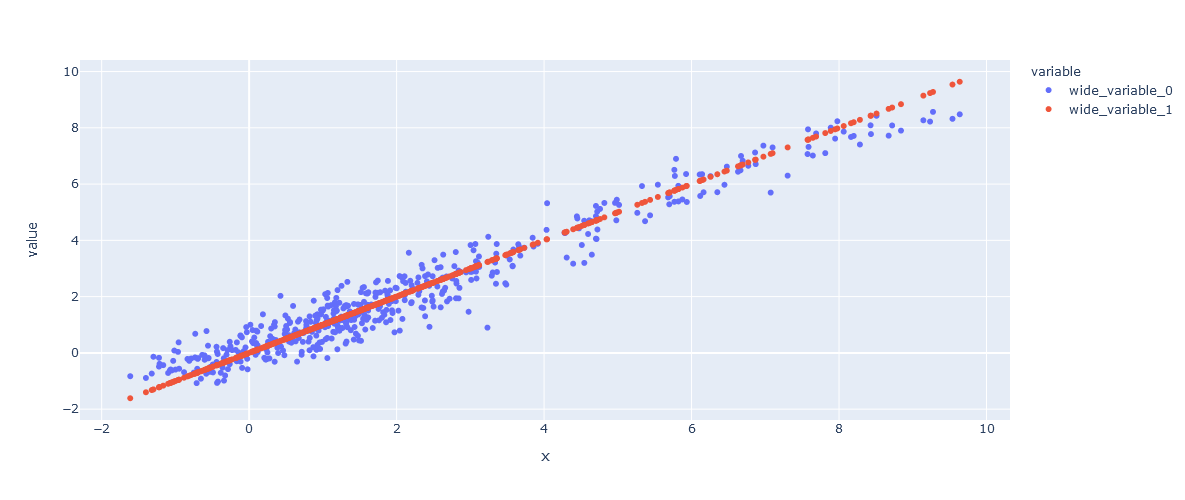

In [28]:
fig = px.scatter(x=y, y=[sol["basis"]@sol["coef_"], y], )
fig.update_layout(height=500, width=500)

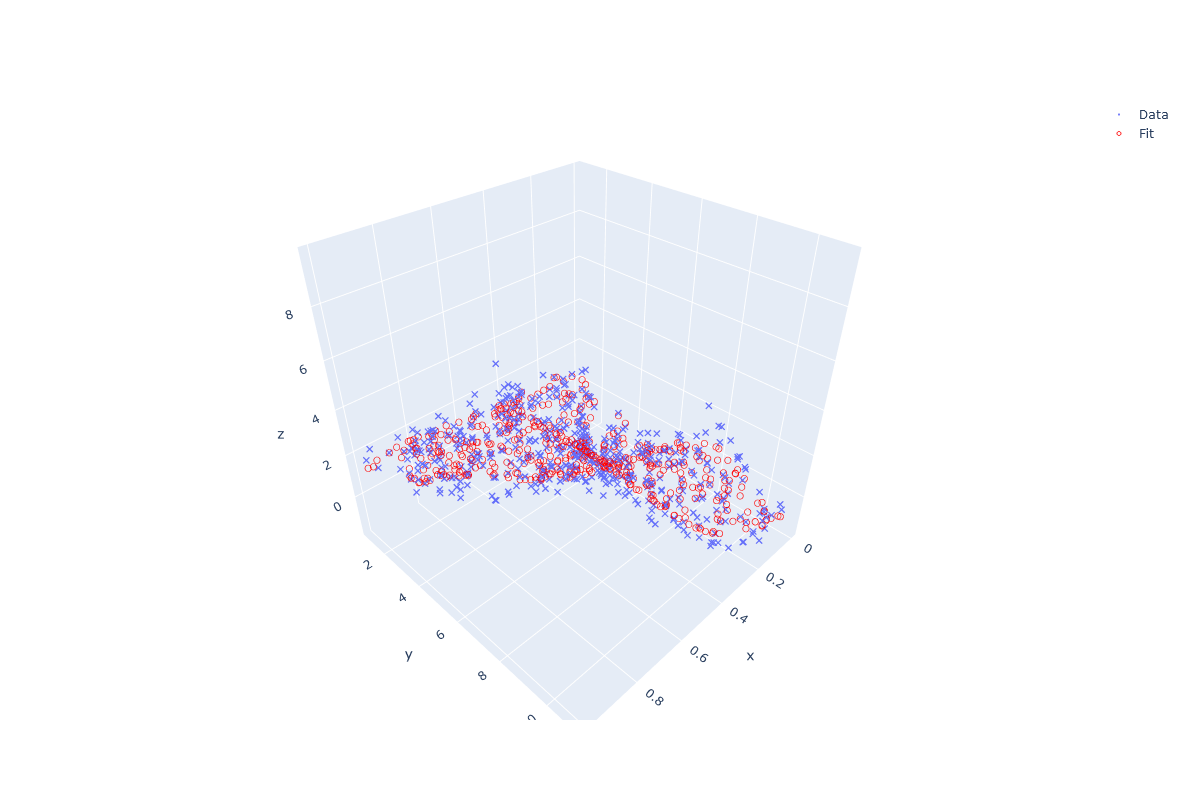

In [37]:
fig = go.Figure()
fig.add_trace(go.Scatter3d(x=XX[:,0], y=XX[:,1], z=y, mode="markers", marker=dict(size=2, symbol="x"), name="Data"))
fig.add_trace(go.Scatter3d(x=XX[:,0], y=XX[:,1], z=sol["basis"]@sol["coef_"], mode="markers", marker=dict(size=4, symbol="circle-open", color="red"), name="Fit"))
fig.update_layout(height=800, width=800)

In [35]:
np.concatenate(basis, axis=1).shape

(25, 50)

In [74]:
m = ( ("t(1,2)", (5,5), ("conc", "inc"), 6000, ("e", "q")), 
      ("s(1)", 10, "dec", 6000, "e"), 
      ("s(2)", 15, "inc", 6000, "q"), 
 )
coef = np.arange(50)
coef[:]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [91]:
v = check_constraint_full(coef, m, basis=basis_matrix, y=y)

Nr of coef:  (5, 5)
Nr of coef:  10
Nr of coef:  15


In [89]:
len(v[0][0])

15

## Generate some 1-D data 

In [346]:
np.random.seed(1)
x = np.linspace(0,6,1000)
xval = np.linspace(0, 6, 1000)
#x = np.random.permutation(x)
y = 0.5*np.sin(x**2) + 10*np.exp(-(x-3.2)**2) + np.random.normal(size=x.shape) * 0.5
#y = np.exp(-(x - 3)**2 / 0.1) *
yval = 0.5*np.sin(xval**2) + 10*np.exp(-(xval-3.2)**2)

#x, xval, y, yval = train_test_split(x, y, test_size=0.2)

x = x / 6
xval = xval / 6
n = 50

Test lam_1= 1e-08	Test lam_2= 1.4508287784959402e-08	Test lam_3= 2.104904144512022e-08	Test lam_4= 3.053855508833412e-08	Test lam_5= 4.4306214575838774e-08	Test lam_6= 6.42807311728432e-08	Test lam_7= 9.3260334688322e-08	Test lam_8= 1.3530477745798075e-07	Test lam_9= 1.9630406500402725e-07	Test lam_10= 2.848035868435805e-07	Test lam_11= 4.1320124001153343e-07	Test lam_12= 5.994842503189409e-07	Test lam_13= 8.697490026177835e-07	Test lam_14= 1.261856883066021e-06	Test lam_15= 1.8307382802953698e-06	Test lam_16= 2.656087782946684e-06	Test lam_17= 3.853528593710536e-06	Test lam_18= 5.590810182512223e-06	Test lam_19= 8.111308307896873e-06	Test lam_20= 1.1768119524349992e-05	Test lam_21= 1.7073526474706923e-05	Test lam_22= 2.477076355991714e-05	Test lam_23= 3.5938136638046256e-05	Test lam_24= 5.214008287999695e-05	Test lam_25= 7.56463327554629e-05	Test lam_26= 0.00010974987654930568	Test lam_27= 0.0001592282793341094	Test lam_28= 0.00023101297000831627	Test lam_29= 0.00033516026509388476	Te

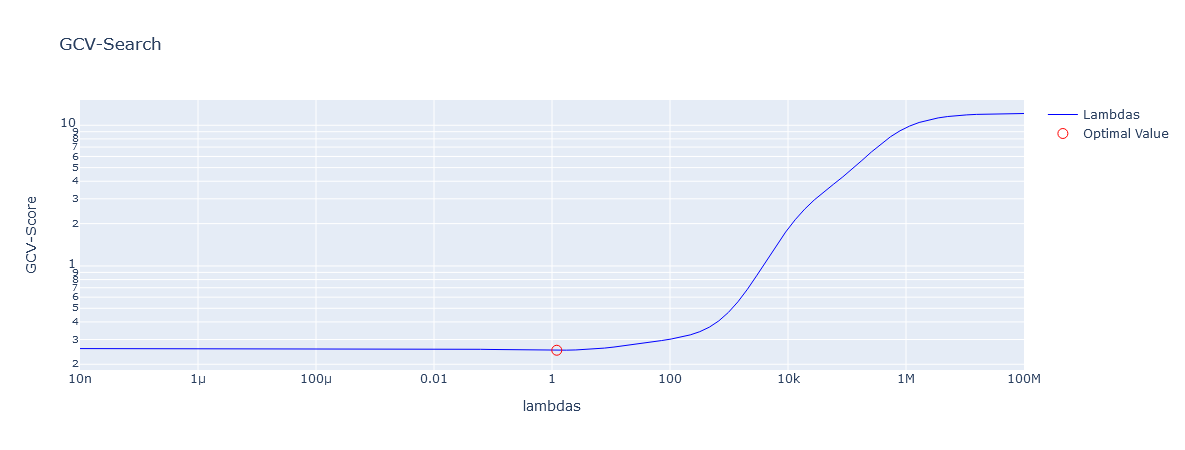

========Pre-Iteration=========
-------MSE = 0.2373703--------
======== Iteration 1 =========
-------MSE = 0.2521434--------
======== Iteration 2 =========
-------MSE = 0.2553299--------


In [347]:
B = Bspline()
sol_gcv = B.calc_GCV(x, y, n, 3, "e", nr_lam=100, plot_=0)
sol_Pspline = B.fit_Pspline(x, y, n, 3, "e", lam=sol_gcv["best_lambda"])
sol_cpsplines = B.fit_constrained_Pspline(X=x, y=y, constraint="peak", nr_splines=n, lam_c=6000)

In [348]:
sol = B.fit(x, y, n, 3, "e")
ypred = B.predict(xval, sol["coef_"], sol["knots"], 3)
ypred_Pspline = B.predict(xval, sol_Pspline["coef_"], sol_Pspline["knots"], 3)
ypred_constrPspline = B.predict(xval, sol_cpsplines["coef_"], sol_cpsplines["knots"], 3)


---Prediction for 1-D Data----
---Prediction for 1-D Data----
---Prediction for 1-D Data----


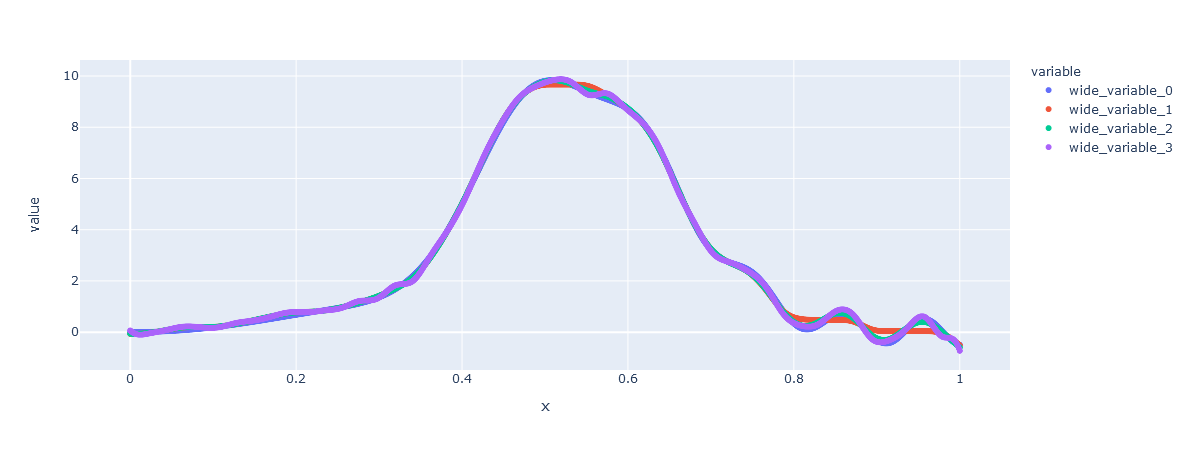

In [349]:
px.scatter(x=xval, y=[yval, ypred_constrPspline, ypred_Pspline, ypred])

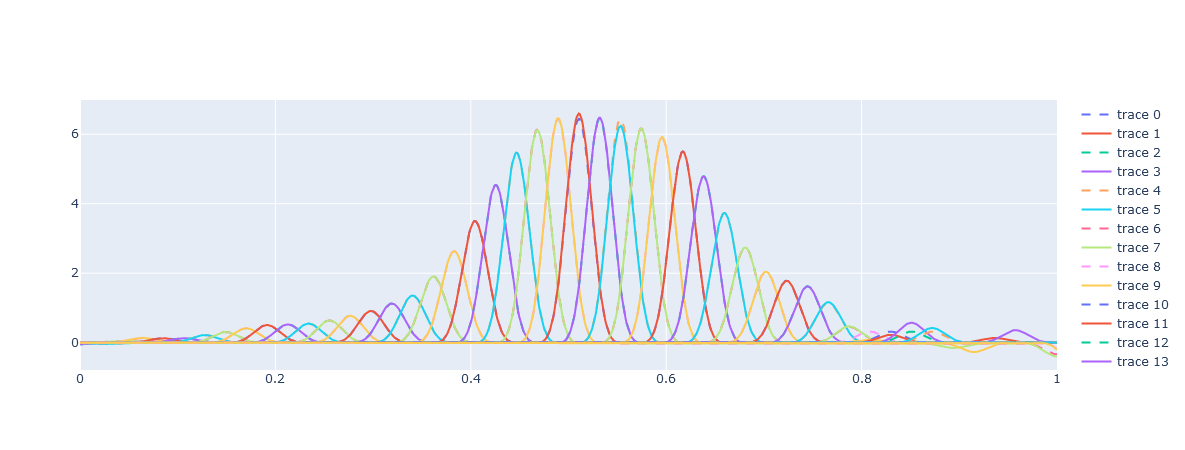

In [13]:
fig = go.Figure()

for i in range(0, sol_cpsplines["basis"].shape[1]):
    fig.add_trace(go.Scatter(x=x, y=sol_cpsplines["basis"][:,i]*sol_cpsplines["coef_"][i], line=dict(dash="dash")))
    fig.add_trace(go.Scatter(x=x, y=sol_Pspline["basis"][:,i]*sol_Pspline["coef_"][i]))
fig.show()


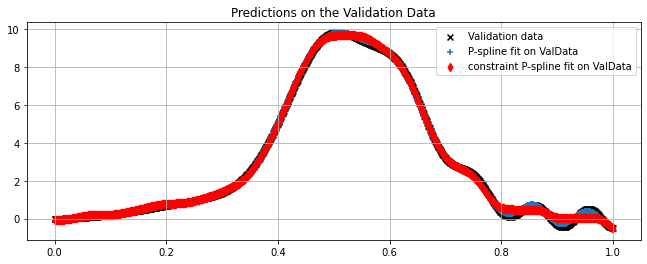

In [21]:

fig, ax = plt.subplots(figsize=(11,4))
ax.set_title("Predictions on the Validation Data")
ax.scatter(xval, yval, marker="x", s=35, c="black", label="Validation data")
ax.scatter(xval, ypred_Pspline, marker="+", label="P-spline fit on ValData")
ax.scatter(xval, ypred_constrPspline, c="red", marker="d", label="constraint P-spline fit on ValData")
ax.grid()
ax.legend()


## Generate some 2-D data

In [350]:
x = np.array([np.linspace(0,2,210), np.linspace(0,1,210)]).T
xval = np.array([np.random.uniform(0,2,1000), np.random.uniform(0,10,1000)]).T

def zfunc(x1, x2): return np.exp(-(x1 - 0.5)**2 - (x2 - 0.5)**2/0.1) - 0.5*x1**2
z = zfunc(x[:,0], x[:,1]) + np.random.normal(size=x[:,0].size) * 0.2
zval = zfunc(xval[:,0], xval[:,1])

xg, yg = np.meshgrid(x[::2,0], x[::2,1])
zg = zfunc(xg[:], yg[:]) + np.random.normal(size=xg.shape)*0.1

Test lam_1= 1e-08	Test lam_2= 2.1209508879201927e-08	Test lam_3= 4.498432668969444e-08	Test lam_4= 9.540954763499944e-08	Test lam_5= 2.0235896477251556e-07	Test lam_6= 4.2919342601287785e-07	Test lam_7= 9.102981779915227e-07	Test lam_8= 1.9306977288832498e-06	Test lam_9= 4.094915062380419e-06	Test lam_10= 8.68511373751352e-06	Test lam_11= 1.8420699693267162e-05	Test lam_12= 3.906939937054613e-05	Test lam_13= 8.286427728546843e-05	Test lam_14= 0.00017575106248547893	Test lam_15= 0.0003727593720314938	Test lam_16= 0.0007906043210907685	Test lam_17= 0.0016768329368110067	Test lam_18= 0.0035564803062231283	Test lam_19= 0.0075431200633546075	Test lam_20= 0.015998587196060572	Test lam_21= 0.03393221771895323	Test lam_22= 0.07196856730011514	Test lam_23= 0.15264179671752304	Test lam_24= 0.323745754281764	Test lam_25= 0.6866488450042998	Test lam_26= 1.4563484775012443	Test lam_27= 3.088843596477472	Test lam_28= 6.551285568595496	Test lam_29= 13.89495494373136	Test lam_30= 29.4705170255181	Test

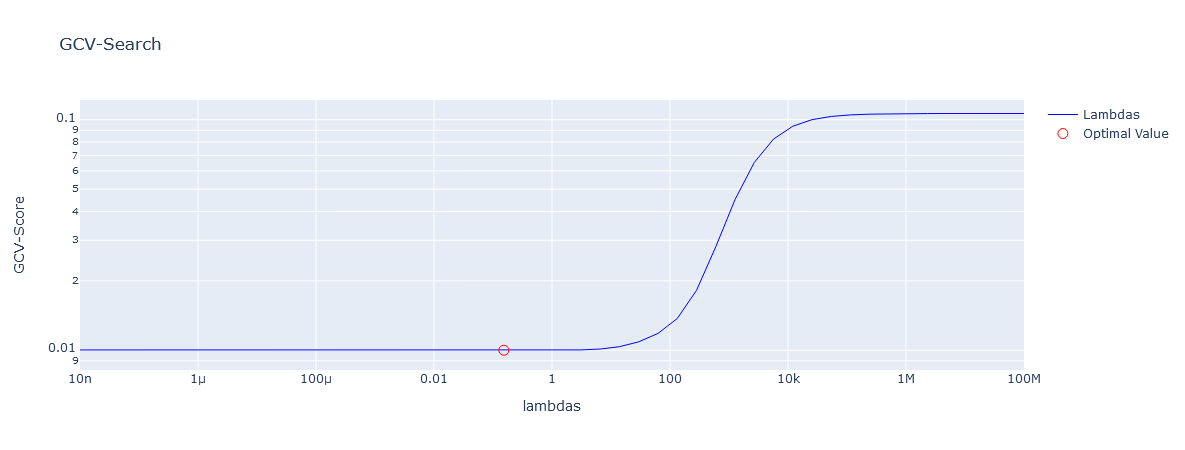

-unconstrained MSE = 0.009895-
======== Iteration 1 =========
--------MSE = 0.010048--------
======== Iteration 2 =========
-------MSE = 0.0100721--------
======== Iteration 3 =========
-------MSE = 0.0100741--------


<AxesSubplot:>

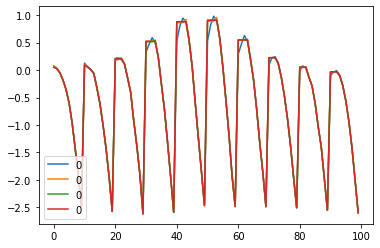

In [352]:
X = np.vstack((xg.ravel(), yg.ravel())).T

T = Bspline()

sol_c_tp_pspline = T.fit_constrained_TP_Pspline(X=X, y=zg.ravel(), constraints=("dec", "none"), nr_splines=(10,10), lam_c=(6000,6000))

df = sol_c_tp_pspline["df_coef"]
df.plot()

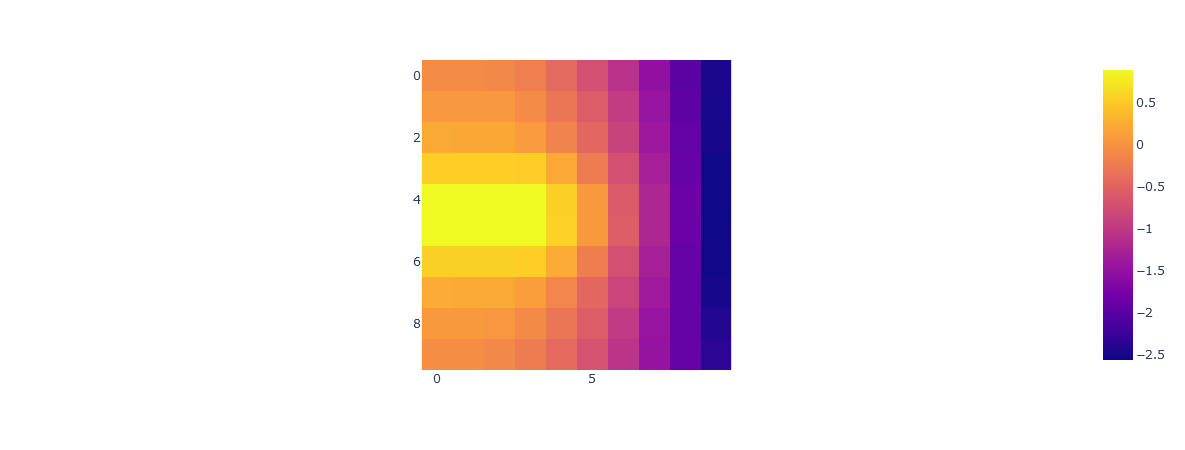

In [233]:
px.imshow(sol_c_tp_pspline["coef_"].reshape(10,10))

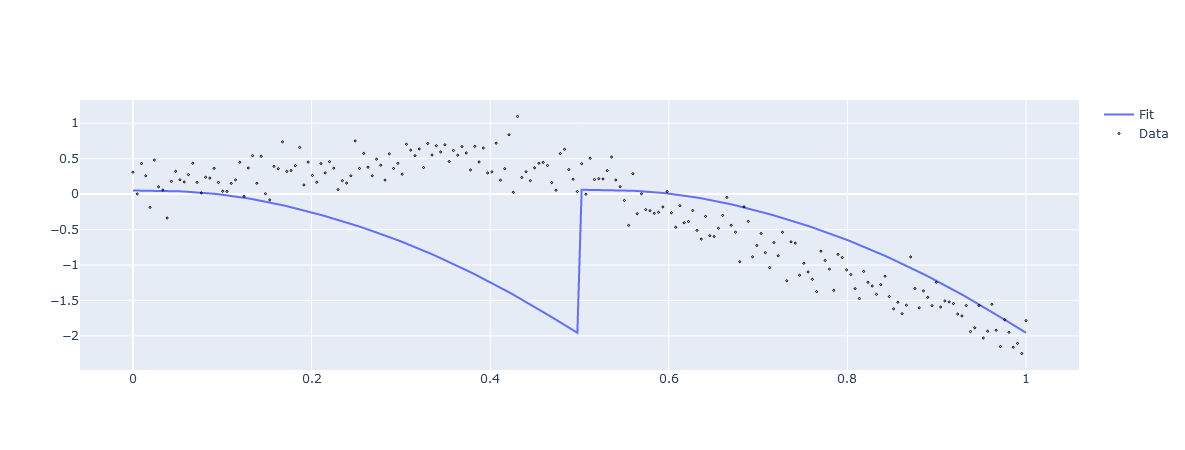

In [17]:
fig = go.Figure()
#fig.add_trace(go.Surface(x=xg, y=yg, z=zg))
fig.add_trace(go.Scatter(x=x[:,1], y=sol_c_tp_pspline["basis"]@sol_c_tp_pspline["coef_"], name="Fit"))
fig.add_trace(go.Scatter(x=x[:,1], y=z, mode="markers",marker=dict(size=2, symbol=100, color="black"), name="Data"))

In [25]:
nr_s=[25,25]
l=[3,3]
knot_types=["e", "e"]

T = Bspline()
sol_gcv = T.calc_GCV(x, z, nr_s, l, knot_types, nr_lam=100, plot_=0)
sol_tp_bspline = T.fit(X=x, y=z, nr_splines=nr_s, l=l, knot_type=knot_types)
sol_tp_pspline = T.fit_Pspline(X=x, y=z, nr_splines=nr_s, l=l, knot_type=knot_types, lam=(sol_gcv["best_lambda"], sol_gcv["best_lambda"]))
sol_c_tp_pspline = constraint_TP_Pspline(X=x, y=z, constraints=("none", "inc"), nr_splines=nr_s, lam=(sol_gcv["best_lambda"], sol_gcv["best_lambda"]))

In [26]:
print("MSE tensor-prodcut B-spline = ", sum((zval- T.predict(Xpred=xval, coef=sol_tp_bspline["coef_"], 
                                                             knots=sol_tp_bspline["knots"], l=l))**2) / z.size)

print("MSE tensor-product P-spline = ", sum((zval- T.predict(Xpred=xval, coef=sol_tp_pspline["coef_"], 
                                                             knots=sol_tp_pspline["knots"], l=l))**2) / z.size)
print("MSE constraint tensor-product P-spline = ", sum((zval- T.predict(Xpred=xval, coef=sol_c_tp_pspline["coef_"], 
                                                                        knots=sol_c_tp_pspline["knots"], l=l))**2) / z.size)

---Prediction for 2-D Data----
MSE tensor-prodcut B-spline =  68771.63656996346
---Prediction for 2-D Data----
MSE tensor-product P-spline =  3.8628917276658568
---Prediction for 2-D Data----
MSE constraint tensor-product P-spline =  4.7256644970889745


---Prediction for 2-D Data----
---Prediction for 2-D Data----
---Prediction for 2-D Data----
---Prediction for 2-D Data----


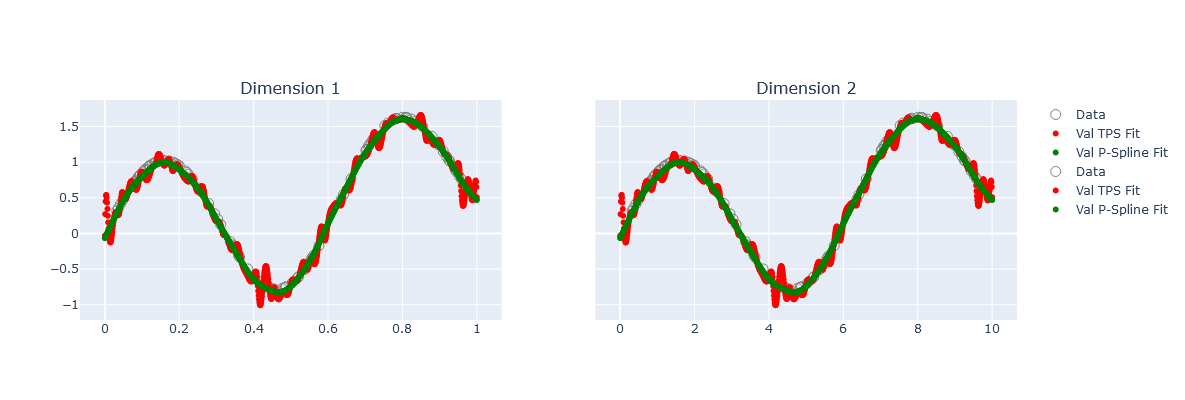

In [73]:
fig = make_subplots(rows=1, cols=2, column_titles=["Dimension 1", "Dimension 2"], shared_yaxes=True, shared_xaxes=True)

for i in range(0,2):
    
    fig.add_trace(go.Scatter(x=xval[::10,i], y=zval[::10], mode="markers", marker=dict(size=10, symbol=100, color="grey"), name="Data"), row=1, col=i+1)
    fig.add_trace(go.Scatter(x=xval[:,i], y=T.predict(xval, T_bspline_sol["coef_"], T_bspline_sol["knots"], l), mode="markers", marker=dict(color="red"), name="Val TPS Fit"),  row=1, col=i+1)
    fig.add_trace(go.Scatter(x=xval[:,i], y=T.predict(xval, ps_coef__, T_bspline_sol["knots"], l), mode="markers", marker=dict(color="green"),name="Val P-Spline Fit"),  row=1, col=i+1)


fig.update_layout(autosize=False, width=900, height=400,)
fig.show()